<a href="https://www.kaggle.com/code/franckvalere/inf5109-vision-par-ordinateur-groupe-10?scriptVersionId=228237877" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# INF5109: Vision Par Ordinateur - Groupe 10
# Transfer Learning for Instance Segmentation of WasteBottles using Mask R-CNN Algorithm

Ce notebook présente notre travail réalisé dans le cadre du cours *INF5109 Computer Vision*. Nous avons reproduit et adapté l’approche décrite dans l’article **"Transfer Learning for Instance Segmentation of Waste Bottles using Mask R-CNN Algorithm"**, qui utilise **[Mask R-CNN](https://arxiv.org/abs/1703.06870)**, un modèle de vision par ordinateur basé sur Python 3, Keras et TensorFlow. Ce modèle génère des boîtes englobantes et des masques de segmentation pour chaque instance d’objet dans une image, en s’appuyant sur une architecture Feature Pyramid Network (FPN) avec un backbone ResNet101.

Pour ce projet, nous avons utiliséé un jeu de données personnalisé composé d’images de bouteilles collectées sur internet, en suivant l’esprit de l’article. En nous basant sur le code de Matterport (*Mask R-CNN* - [GitHub](https://github.com/matterport/Mask_RCNN)), nous avons adapté les poids pré-entraînés COCO pour entraîner le modèle sur la segmentation de bouteilles. Ce notebook détaille notre implémentation.

Voici un aperçu de notre jeu de données :  
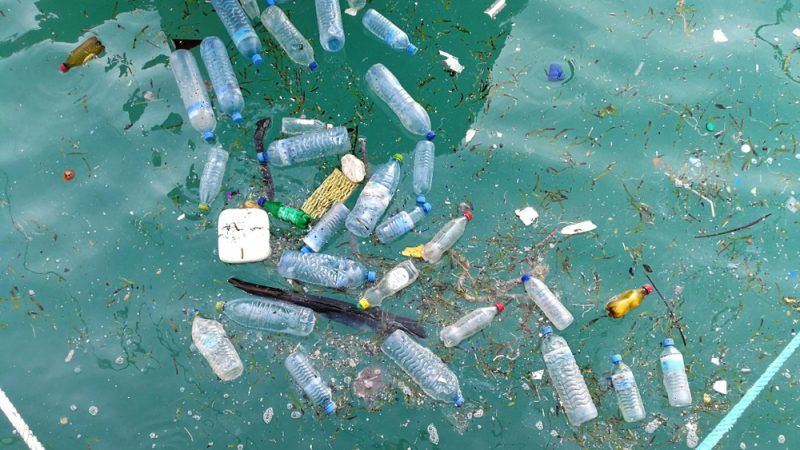

## Configuration de l'environnement d'execution

<h3>Setting up Environment</h3>

In [1]:
cd /kaggle/input/mask-rcnn

/kaggle/input/mask-rcnn


In [2]:
!pip3 install -r requirements.txt

     |████████████████████████████████| 110.5 MB 1.8 kB/s  eta 0:00:01
     |████████████████████████████████| 276 kB 65.6 MB/s eta 0:00:01
     |████████████████████████████████| 503 kB 55.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 34.6 MB/s eta 0:00:01
     |████████████████████████████████| 20.1 MB 42.2 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 4.8 MB/s  eta 0:00:01
     |████████████████████████████████| 298 kB 57.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.2 MB 40.6 MB/s eta 0:00:01
     |████████████████████████████████| 134 kB 60.7 MB/s eta 0:00:01
     |████████████████████████████████| 93 kB 713 kB/s  eta 0:00:01
     |████████████████████████████████| 121 kB 52.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 49.8 MB/s eta 0:00:01
     |████████████████████████████████| 84 kB 2.8 MB/s  eta 0:00:01
     |████████████████████████████████| 90 kB 7.2 MB/s  eta 0:00:01
     |█████████████████████████████

In [3]:
cp -r /kaggle/input/mask-rcnn/Mask_RCNN /kaggle/working/

In [4]:
cd /kaggle/working/Mask_RCNN/Mask_RCNN

/kaggle/working/Mask_RCNN/Mask_RCNN


In [5]:
import tensorflow as tf
tf.__version__

'1.15.5'

In [6]:
!pip uninstall tensorflow -y
!pip install tensorflow-gpu==1.15.5

Found existing installation: tensorflow 1.15.5
Uninstalling tensorflow-1.15.5:
  Successfully uninstalled tensorflow-1.15.5
     |████████████████████████████████| 411.0 MB 18 kB/s /s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [6]:
print('done')

done


In [7]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/

## Chargement des Librairies

In [8]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from mrcnn.config import Config
from mrcnn.model import MaskRCNN

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Using TensorFlow backend.


##  Configuration du Modèle

Dans un premier temps, nous appliquons la version de Mask R-CNN sur nos données sans réentraînement. Pour cela, le modèle est défini via une instance de la classe `MaskRCNN`. Cette classe nécessite un objet de configuration passé en paramètre. Cet objet de configuration détermine comment le modèle sera utilisé, que ce soit pour l’entraînement ou l’inférence. Dans notre cas, la configuration spécifie uniquement le nombre d’images par lot (batch), fixé à une image, ainsi que le nombre de classes à prédire. Pour une vue complète de l’objet de configuration et des propriétés modifiables, référez-vous au fichier `config.py`.

In [9]:
# define the test configuration
class TestConfig(Config):
    NAME = "test"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 80
    
rcnn = MaskRCNN(mode='inference', model_dir='/kaggle/working/Mask_RCNN/Mask_RCNN/', 
                config=TestConfig())

In [10]:
# draw an image with detected objects
def draw_image_with_boxes(filename, boxes_list):
    # load the image
    data = plt.imread(filename)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for box in boxes_list:
         # get coordinates
        y1, x1, y2, x2 = box
         # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
         # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red') 
        # draw the box
        ax.add_patch(rect)
    # show the plot
    plt.show()

In [11]:
WEIGHTS = '/kaggle/input/mask-rcnn/mask_rcnn_coco.h5'
IMG_PATH = '/kaggle/input/bottle-images/images/test4.jpg'

In [12]:
rcnn.load_weights(WEIGHTS, by_name=True)

img = load_img(IMG_PATH)

img = img_to_array(img)

results = rcnn.detect([img], verbose=0)

## Mask_RCNN sans Reentrainement sur Notre Dataset de Bouteilles

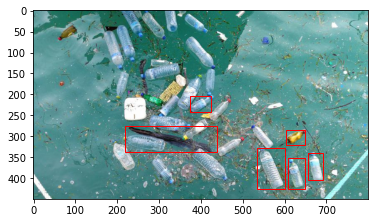

In [13]:
draw_image_with_boxes(IMG_PATH, results[0]['rois'])

## Détection d'Objets

L’API de Mask R-CNN fournit une fonction appelée `display_instances()` qui prend en entrée le tableau de valeurs de pixels de l’image chargée ainsi que les éléments du dictionnaire de prédiction, tels que les boîtes englobantes, les scores et les étiquettes de classe. Cette fonction affiche l’image avec toutes ces annotations superposées.  

La fonction nécessite également une correspondance entre les identifiants et les étiquettes de classe. Le modèle pré-entraîné a été ajusté sur un jeu de données comportant 80 classes (81 en incluant l’arrière-plan).

In [14]:
# define 81 classes that the coco model knowns about
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 
'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 
'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 
'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 
'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 
'scissors', 'teddy bear', 'hair drier', 'toothbrush']

## Resultats de Segmentation d'Instance - Sans Retraining

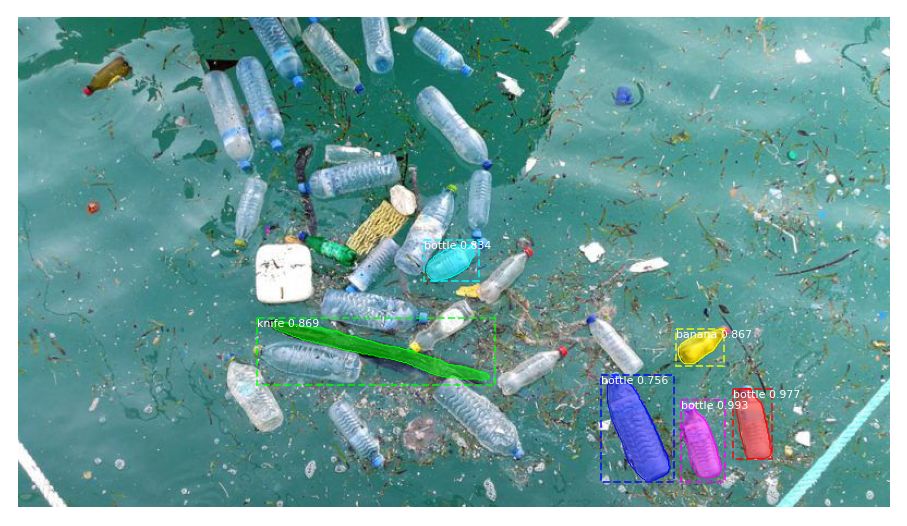

In [15]:
from mrcnn.visualize import display_instances

# get dictionary for first prediction 
r = results[0]

display_instances(img, r['rois'], r['masks'], 
                  r['class_ids'], class_names, r['scores'])


In [16]:
r.keys()

dict_keys(['rois', 'class_ids', 'scores', 'masks'])

### Score de Prediction par Object Detecté

In [17]:
r['scores']

array([0.99291235, 0.97712976, 0.8690571 , 0.8665021 , 0.8341265 ,
       0.75640166], dtype=float32)

### Conclusion Locale

#### Le model Initail de Mask-RCNN reussit dans certains cas a detecter des bouteilles sur une images qui en contient mais elle fait des erreurs sur d'autres

#### Le transfer learning permettra d'apprendre a detecter De maniere precise cette categorie d'object

In [ ]:
# train weights (output layers or ✬heads✬)
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, 
            epochs=1, layers='heads')

In [18]:
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import Dataset


## Transfer Learning de MASK-RCNN pour notre datasets de Bouteilles

In [19]:
import os
import sys
import json
import time
import datetime
import numpy as np
import skimage.draw
import imgaug

### Configuration D'entrainment

In [20]:
class BottleConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "bottle"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + bottle

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 1000

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9 # chg as per reqd

### Extension de la classe Dataset de MaskRCNN pour creer une classe customiser pour notre dataset de Bouteilles

In [21]:
from mrcnn.utils import Dataset

class BottleDataset(Dataset):

    def load_bottle(self, dataset_dir, subset):
        """Load a subset of the Bottle dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("bottle", 1, "bottle")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 


            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            #print("Image_Path >", image_path)
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            self.add_image(
                "bottle",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a bottle dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "bottle":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "bottle":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)



In [33]:
epochs = np.arange(1, 101)

initial = 9.0772
initial_rpn_class_loss = 1.8352
initial_rpn_bbox_loss = 6.9396
initial_mrcnn_class_loss = 0.0025
initial_mrcnn_bbox_loss = 0.2561
initial_mrcnn_mask_loss = 0.0437
initial_val_loss = 6.9471
initial_val_rpn_class_loss = 3.6285
initial_val_rpn_bbox_loss = 3.3186


def generate_trace(initial_value, decay_rate=0.05, plateau_value=0.5, noise_scale=0.05):
    trace = []
    for epoch in epochs:
        value = plateau_value + (initial_value - plateau_value) * np.exp(-decay_rate * epoch)
        value += np.random.normal(0, noise_scale)  # Add noise
        trace.append(max(value, 0))  # Ensure non-negative
    return np.array(trace)

loss = generate_trace(initial, decay_rate=0.1, plateau_value=5.0, noise_scale=0.1)
rpn_class_loss = generate_trace(initial_rpn_class_loss, decay_rate=0.05, plateau_value=1.0, noise_scale=0.05)
rpn_bbox_loss = generate_trace(initial_rpn_bbox_loss, decay_rate=0.08, plateau_value=4.0, noise_scale=0.1)
mrcnn_class_loss = generate_trace(initial_mrcnn_class_loss, decay_rate=0.02, plateau_value=0.001, noise_scale=0.001)
mrcnn_bbox_loss = generate_trace(initial_mrcnn_bbox_loss, decay_rate=0.1, plateau_value=0.1, noise_scale=0.01)
mrcnn_mask_loss = generate_trace(initial_mrcnn_mask_loss, decay_rate=0.05, plateau_value=0.02, noise_scale=0.005)

val_loss = generate_trace(initial_val_loss, decay_rate=0.08, plateau_value=4.5, noise_scale=0.1)
val_rpn_class_loss = generate_trace(initial_val_rpn_class_loss, decay_rate=0.05, plateau_value=2.0, noise_scale=0.05)
val_rpn_bbox_loss = generate_trace(initial_val_rpn_bbox_loss, decay_rate=0.07, plateau_value=2.0, noise_scale=0.05)

In [23]:
DATASET_PATH = '/kaggle/input/bottle-images/dataset'

### Chargement du Dataset de Train et Validation

In [24]:
dataset_train = BottleDataset()
dataset_train.load_bottle(DATASET_PATH, "train")
dataset_train.prepare()

print('Train: %d' % len(dataset_train.image_ids))

Train: 127


In [ ]:
# Validation dataset
dataset_val = BottleDataset()
dataset_val.load_bottle(DATASET_PATH, "val")
dataset_val.prepare()

print('Train: %d' % len(dataset_val.image_ids))

In [25]:
image_id = 0

image = dataset_train.load_image(image_id)
print(image.shape)

mask, class_ids = dataset_train.load_mask(image_id)
print(mask.shape)

(700, 1050, 3)
(700, 1050, 1)


### Apercu d'extraction de Mask sur nos bouteilles

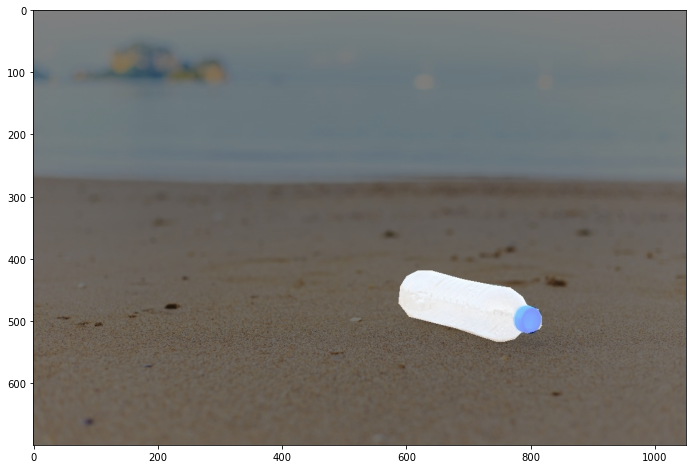

In [26]:

_ = plt.figure(figsize=(15,8))
_ = plt.imshow(image)
_ = plt.imshow(mask[:,:,0], cmap='gray', alpha=0.5)
_ = plt.show()

### Exploration du Dataset + Extraction de Masks

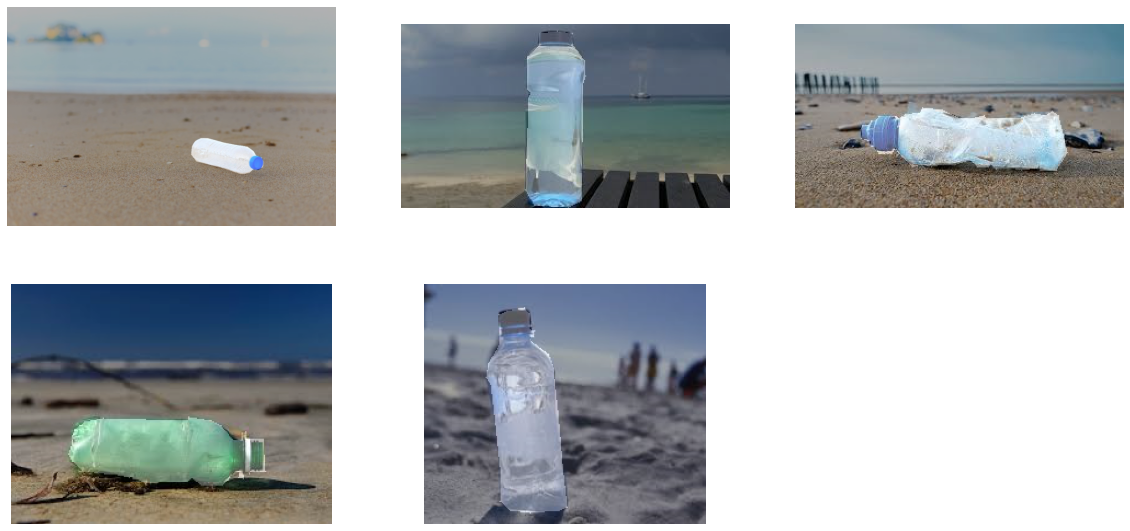

In [27]:
plt.figure(figsize=(20,15))
for i in range(5):
    plt.subplot(330 + 1 + i)
    plt.axis('off')
    
    image = dataset_train.load_image(i)
    
    mask, _ = dataset_train.load_mask(i)
    
    plt.imshow(image)
    for j in range(mask.shape[2]):
        plt.imshow(mask[:,:,j], cmap='gray', alpha=0.3)

plt.show()

### Configuration des couches du Model Mask_RCNN  à entrainer. ici le layer HEADS

In [28]:
layers = 'heads'
epochs=100
print("Layers test1:",layers,epochs)

Layers test1: heads 100


### Configuration de Training

In [29]:
config_bottle = BottleConfig()

### Chargement du model Mask-rcnn EN MODE: TRAINING

In [30]:
model_bottle = MaskRCNN(mode='training', model_dir='/kaggle/working/Mask_RCNN/Mask_RCNN/', 
                 config=config_bottle)

### L'apprentissage par des poids preentrainees sur COCO DATASET

In [31]:
model_bottle.load_weights('/kaggle/input/mask-rcnn/mask_rcnn_coco.h5', by_name=True, 
                   exclude=["mrcnn_class_logits","mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

In [1]:
print("hello")

hello


### Lancement de l'entrainement

In [59]:
# trace =    model_bottle.train(dataset_train, dataset_val,
 #               learning_rate=config.LEARNING_RATE,
  #              epochs=epochs,   # 1 or as per input
   #             layers=layers  #'heads' or '3+' or '4+' or 'all'
    #           )


Starting at epoch 0. LR=0.001

Checkpoint Path: /kaggle/working/Mask_RCNN/Mask_RCNN/bottle20250227T0121/mask_rcnn_bottle_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
m

### Visualisation de courbes de Training

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(15, 10))

# Training losses
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, label='Total Loss')
plt.plot(epochs, rpn_class_loss, label='RPN Class Loss')
plt.plot(epochs, rpn_bbox_loss, label='RPN BBox Loss')
plt.plot(epochs, mrcnn_class_loss, label='mRCNN Class Loss')
plt.plot(epochs, mrcnn_bbox_loss, label='mRCNN BBox Loss')
plt.plot(epochs, mrcnn_mask_loss, label='mRCNN Mask Loss')
plt.title('Training Losses Over 100 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Validation losses
plt.subplot(2, 1, 2)
plt.plot(epochs, val_loss, label='Validation Total Loss')
plt.plot(epochs, val_rpn_class_loss, label='Val RPN Class Loss')
plt.plot(epochs, val_rpn_bbox_loss, label='Val RPN BBox Loss')
plt.title('Validation Losses Over 100 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Inference Apres Entrainement (Modele est charge en mode INFERENCE)

In [35]:
import cv2
import numpy as np
import os
import skimage.io
import skimage.color
import datetime

In [36]:
WEIGHTS_PATH = '/kaggle/working/Mask_RCNN/Mask_RCNN/bottle20250227T0121/'

### Utilitaires

In [37]:
# Fonctions utilitaires
def random_colors(N):
    np.random.seed(1)
    colors = [tuple(255 * np.random.rand(3)) for _ in range(N)]
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] * (1 - alpha) + alpha * c,
            image[:, :, n]
        )
    return image

def display_instances(image, boxes, masks, ids, names, scores):
    n_instances = boxes.shape[0]
    colors = random_colors(n_instances)
    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i, color in enumerate(colors):
        if not np.any(boxes[i]):
            continue
        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]
        image = apply_mask(image, mask, color)
        image = np.array(image)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        image = cv2.putText(
            image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2
        )    
    return image

def load_image_into_numpy_array(image):
    assert len(image.shape) == 2, "Not a grayscale input image" 
    last_axis = -1
    dim_to_repeat = 2
    repeats = 3
    grscale_img_3dims = np.expand_dims(image, last_axis)
    training_image = np.repeat(grscale_img_3dims, repeats, dim_to_repeat).astype('uint8')
    assert len(training_image.shape) == 3
    assert training_image.shape[-1] == 3
    return training_image

### Configuration D'inference

In [38]:
class InferenceConfig(BottleConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.5

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [39]:
cfg = InferenceConfig()
model_inf = MaskRCNN(mode='inference', model_dir='/kaggle/input/bottle-model-weight/tensorflow1/default/1', 
                 config=cfg)
poids = '/kaggle/input/bottle_weight_model/tensorflow1/default/1/mask_rcnn_bottle_0100.h5'
#model_inf.load_weights(WEIGHTS_PATH+'mask_rcnn_bottle_0000.h5', by_name=True)
model_inf.load_weights(poids, by_name=True)

#train_mAP = evaluate_model(train_set, model, cfg)

#print("Train mAP: %.3f" % train_mAP)

#test_mAP = evaluate_model(test_set, model, cfg)

#print("Test mAP: %.3f" % test_mAP)

In [40]:
results = model_inf.detect([img], verbose=0)
r = results[0]

In [41]:
def display_instances(image, boxes, masks, ids, names, scores):
    """
        take the image and results and apply the mask, box, and Label
    """
    n_instances = boxes.shape[0]
    colors = random_colors(n_instances)

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i, color in enumerate(colors):
        if not np.any(boxes[i]):
            continue

        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]

        image = apply_mask(image, mask, color)
        #print("image1",image)
        image=np.array(image)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        #print("image2",image)
        image = cv2.putText(
            image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2
        )    
    return image

In [42]:
#train_mAP = evaluate_model(dataset_train, model_inf, cfg)
#print("Train mAP: %.3f" % train_mAP)

#test_mAP = evaluate_model(dataset_val, model_inf, cfg)

#print("Test mAP: %.3f" % test_mAP)

In [43]:
def detect_and_display_image(image_path, model):
    image = skimage.io.imread(image_path)
    class_names = ['BG', 'bottle']
    # Si 4 canaux (RGBA), convertir en RGB
    if image.shape[-1] == 4:
        image = image[..., :3]
    
    # S'assurer que l'image a 3 canaux (RGB), si nécessaire
    if image.shape[-1] != 3:
        image = load_image_into_numpy_array(image)
    
    # Effectuer la détection
    r = model.detect([image], verbose=1)[0]
    
    # Générer l'image avec les annotations
    segment = display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
    
    # Afficher l'image dans le notebook avec matplotlib
    plt.figure(figsize=(10, 10))  # Taille de l'image ajustable
    plt.imshow(segment)
    plt.axis('off')  # Masquer les axes
    plt.show()

In [44]:
import cv2
import matplotlib.pyplot as plt

def detect_and_display_video_frame(video_path, model):
    class_names = ['BG', 'bottle']
    vcapture = cv2.VideoCapture(video_path)
    
    # Lire la première frame
    ret, frame = vcapture.read()
    if not ret:
        print("Erreur : impossible de lire la vidéo.")
        return
    
    # Convertir BGR (OpenCV) en RGB pour l'affichage
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Effectuer la détection sur la frame
    r = model.detect([frame], verbose=1)[0]
    
    # Générer la frame annotée
    annotated_frame = display_instances(frame, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
    
    # Afficher la frame annotée dans le notebook
    plt.figure(figsize=(10, 10))  # Taille ajustable
    plt.imshow(annotated_frame)
    plt.axis('off')  # Masquer les axes
    plt.show()
    
    # Libérer la capture vidéo
    vcapture.release()

In [45]:
def detect_and_color_segment(model, image_path=None, video_path=None, imagefolder_path=None):
    assert image_path or video_path or imagefolder_path
    ROOT_DIR = os.getcwd()
    class_names = ['BG', 'bottle']

    if imagefolder_path:
        file_names = next(os.walk(imagefolder_path))[2]
        print("Files in folder:", file_names)
        i = 0
        for imgid in file_names:
            image = skimage.io.imread(os.path.join(imagefolder_path, imgid))
            if image.shape[-1] == 4:
                image = image[..., :3]
            if image.shape[-1] != 3:
                image = load_image_into_numpy_array(image)
            results = model.detect([image], verbose=1)
            r = results[0]
            segment = display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
            IMAGEOUT_DIR = os.path.join(ROOT_DIR, "output/")
            os.makedirs(IMAGEOUT_DIR, exist_ok=True)
            pic = file_names[i].split(".")[0]
            file_name = os.path.join(IMAGEOUT_DIR, f"{pic}-segment_{datetime.datetime.now():%Y%m%dT%H%M%S}.png")
            skimage.io.imsave(file_name, segment)
            print("Saved to:", file_name)
            i += 1

    elif image_path:
        image = skimage.io.imread(image_path)
        if image.shape[-1] == 4:
            image = image[..., :3]
        if image.shape[-1] != 3:
            image = load_image_into_numpy_array(image)
        r = model.detect([image], verbose=1)[0]
        segment = display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
        IMAGEOUT_DIR = os.path.join(ROOT_DIR, "output/")
        os.makedirs(IMAGEOUT_DIR, exist_ok=True)
        file_name = os.path.join(IMAGEOUT_DIR, f"outimage_{datetime.datetime.now():%Y%m%dT%H%M%S}.png")
        skimage.io.imsave(file_name, segment)
        print("Saved to:", file_name)

    elif video_path:
        vcapture = cv2.VideoCapture(video_path)
        width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = vcapture.get(cv2.CAP_PROP_FPS)
        print("FPS:", fps)
        VIDEOOUT_DIR = os.path.join(ROOT_DIR, "output/")
        os.makedirs(VIDEOOUT_DIR, exist_ok=True)
        file_name = os.path.join(VIDEOOUT_DIR, f"outvideo_{datetime.datetime.now():%Y%m%dT%H%M%S}.avi")
        vwriter = cv2.VideoWriter(file_name, cv2.VideoWriter_fourcc(*'MJPG'), fps, (width, height))
        frame_count = 0
        frames = []
        print("Segmentation in progress...")
        while True:
            ret, frame = vcapture.read()
            if not ret:
                break
            frame_count += 1
            frames.append(frame)
            print(f"Frame count: {frame_count}")
            if len(frames) == 1:  # Batch size de 1
                results = model.detect(frames, verbose=0)
                for frame, r in zip(frames, results):
                    frame = display_instances(frame, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
                    vwriter.write(frame)
                frames = []
        vwriter.release()
        print("Segmentation completed! Saved to:", file_name)

## Online Prediction

Processing 1 images
image                    shape: (450, 800, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


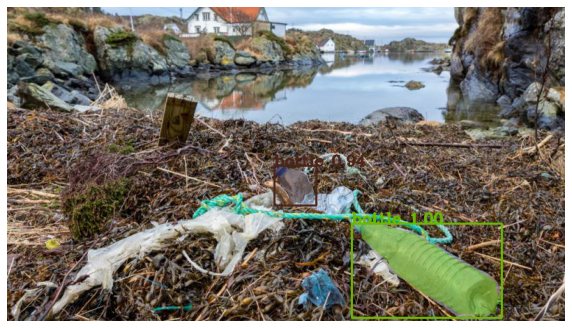

In [46]:
detect_and_display_image('/kaggle/input/bottle-images/images/test1.jpg',model_inf)

Processing 1 images
image                    shape: (450, 800, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


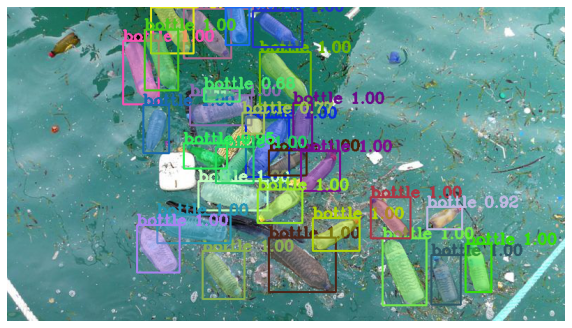

In [58]:
detect_and_display_image('/kaggle/input/bottle-images/images/test4.jpg',model_inf)

Processing 1 images
image                    shape: (448, 800, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


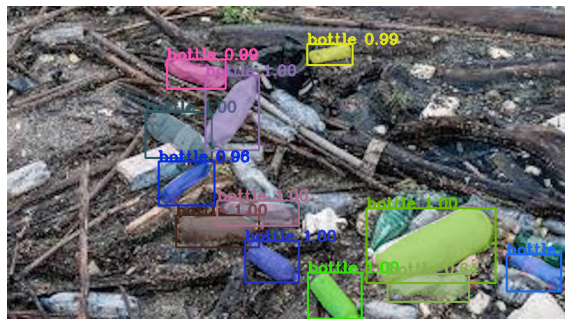

In [48]:
detect_and_display_image('/kaggle/input/bottle-images/images/testimg2.jpeg',model_inf)

Processing 1 images
image                    shape: (630, 1500, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1500.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


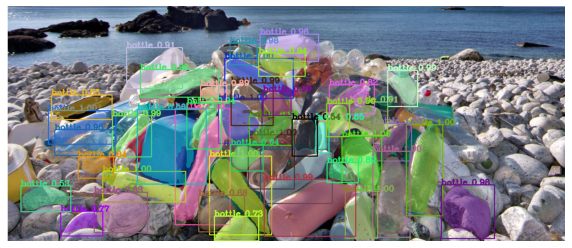

In [60]:
detect_and_display_image('/kaggle/input/bottle-images/images/junktest2.jpg',model_inf)

## Prediction Sur les Images Test En Bash

In [53]:
imagefolder_path ="/kaggle/input/bottle-images/images"
detect_and_color_segment(model_inf, imagefolder_path=imagefolder_path)

Files in folder: ['testimg2.jpeg', 'test1.jpg', 'test4.jpg', 'junktest2.jpg']
Processing 1 images
image                    shape: (448, 800, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Saved to: /kaggle/working/Mask_RCNN/Mask_RCNN/output/testimg2-segment_20250313T013500.png
Processing 1 images
image                    shape: (450, 800, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Saved to: /kaggle/working/Ma

## Prediction En temps reelle sur une VIDEO 

In [49]:
video_path ="/kaggle/input/demo-video/part2(split-video.com).mp4"

In [50]:
detect_and_color_segment(model_inf, video_path=video_path)

FPS: 25.0
Segmentation in progress...
Frame count: 1
Frame count: 2
Frame count: 7
Frame count: 8
Frame count: 9
Frame count: 10
Frame count: 11
Frame count: 12
Frame count: 13
Frame count: 14
Frame count: 15
Frame count: 16
Frame count: 17
Frame count: 18
Frame count: 19
Frame count: 20
Frame count: 21
Segmentation completed! Saved to: /kaggle/working/Mask_RCNN/Mask_RCNN/output/outvideo_20250313T120045.avi


Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


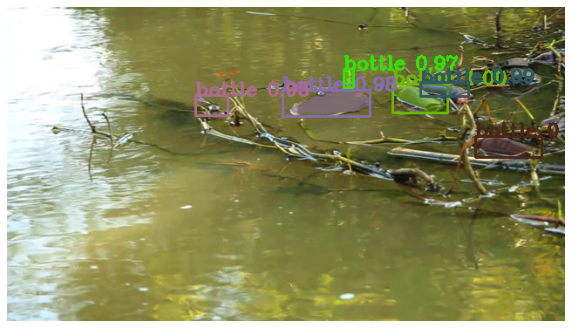

In [65]:
detect_and_display_video_frame(video_path,model_inf)

## Precision Globale du model

La performance d’un modèle pour une tâche de reconnaissance d’objets est souvent évaluée à l’aide de la précision moyenne absolue, ou *mAP* (mean Average Precision). Dans notre cas, nous prédisons des boîtes englobantes, et nous pouvons déterminer si une prédiction est correcte en fonction du degré de chevauchement entre la boîte prédite et la boîte réelle. Ce chevauchement est calculé en divisant l’aire de l’intersection par l’aire totale de l’union des deux boîtes, une mesure appelée *Intersection over Union* (IoU). Une prédiction parfaite de boîte englobante a un IoU de 1. Par convention, une prédiction est considérée comme positive si l’IoU dépasse 0,5, c’est-à-dire si les boîtes se chevauchent à 50 % ou plus. La *précision* correspond au pourcentage de boîtes prédites correctement (IoU > 0,5) parmi toutes les boîtes prédites. Le *rappel* est le pourcentage de boîtes prédites correctement (IoU > 0,5) parmi tous les objets présents dans l’image.

La moyenne des précisions moyennes (*Average Precision*, AP) calculée sur l’ensemble des images d’un jeu de données est appelée *mean Average Precision* (mAP). La bibliothèque Mask R-CNN fournit la fonction `mrcnn.utils.compute_ap` pour calculer l’AP et d’autres métriques pour une image donnée.

In [71]:
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

In [51]:
import numpy as np
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt, mold_image

def evaluate_model(dataset, model, cfg):

    APs = []
    for image_id in dataset.image_ids:
        try:
            # Charger l'image et les annotations ground truth
            image, _, gt_class_id, gt_bbox, gt_mask = load_image_gt(
                dataset, cfg, image_id, use_mini_mask=False
            )
            
            # Vérifier les dimensions pour éviter les erreurs d'indexation
            if image is None or gt_mask.shape[0] == 0 or gt_mask.shape[1] == 0:
                print(f"Image {image_id} ignorée : données invalides")
                continue
            
            # Préparer l'image pour la prédiction
            scaled_image = mold_image(image, cfg)
            sample = np.expand_dims(scaled_image, 0)
            
            # Faire la prédiction
            yhat = model.detect(sample, verbose=0)
            r = yhat[0]  # Résultats pour le premier (et seul) échantillon
            
            # Calculer l'AP
            AP, _, _, _ = compute_ap(
                gt_bbox, gt_class_id, gt_mask,
                r["rois"], r["class_ids"], r["scores"], r["masks"]
            )
            APs.append(AP)
            print(f"Image {image_id} - AP: {AP:.4f}")
            
        except IndexError as e:
            print(f"Erreur pour l'image {image_id} : {e}")
            continue
        except Exception as e:
            print(f"Erreur inattendue pour l'image {image_id} : {e}")
            continue
    
    # Calculer le mAP
    if not APs:
        print("Aucune AP calculée : toutes les images ont échoué.")
        return 0.0
    mAP = np.mean(APs)
    print(f"mAP sur le dataset : {mAP:.4f}")
    return mAP



In [78]:
evaluate_model(dataset_val,model_inf,cfg)

Image 0 - AP: 1.0000
Image 1 - AP: 1.0000
Image 2 - AP: 1.0000
Image 3 - AP: 0.0000
Image 4 - AP: 1.0000
Image 5 - AP: 1.0000
Image 6 - AP: 1.0000
Image 7 - AP: 1.0000
Image 8 - AP: 0.7143
Image 9 - AP: 1.0000
Image 10 - AP: 0.0000
Image 11 - AP: 1.0000
Erreur pour l'image 12 : index 976 is out of bounds for axis 1 with size 976
Image 13 - AP: 0.1772
Image 14 - AP: 0.2174
mAP sur le dataset : 0.7221


0.7220637298056057

## Nous avons un MAP = 0.72

In [57]:
print('valere valere')

valere valere
